In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from nltk.corpus import stopwords

from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('train_data-2.csv', encoding='utf', engine='python', index_col=0)
test = pd.read_csv('test_data-2.csv', encoding='utf', engine='python', index_col=0)

In [3]:
tf_idf = TfidfVectorizer(ngram_range=(1, 4), stop_words=stopwords.words('russian'), 
                         #tokenizer=None,
                         #preprocessor=None,
                         analyzer='word',
                         max_df=0.8, 
                         min_df=10,
                         #max_features=10000
                        )

In [4]:
%%time
tf_idf_model = tf_idf.fit(train['text'])

CPU times: user 13.9 s, sys: 493 ms, total: 14.3 s
Wall time: 14.4 s


In [5]:
%%time
train_tf_idf_vec = tf_idf_model.transform(train['text'])
test_tf_idf_vec = tf_idf_model.transform(test['text'])

CPU times: user 5.5 s, sys: 58.9 ms, total: 5.56 s
Wall time: 5.63 s


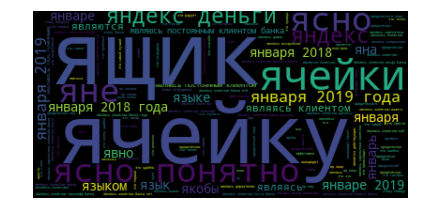

In [6]:
wordcloud = WordCloud().generate_from_frequencies(tf_idf_model.vocabulary_)

# Display the generated image:
plt.figure() 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.margins(x=0, y=0) 
plt.tight_layout()
plt.show() 

In [7]:
lm = LogisticRegression(#solver='newton-cg', 
                        #n_jobs=-1,
                        #solver='lbfgs',
                        penalty='l2',
                        #tol=0.000000001,
                        random_state=42,
                        C=10, 
                        max_iter=100000)

In [8]:
lm_params = {'penalty':['l1', 'l2'],
             'C':np.arange(0.1,5,0.1),
             #'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
             #'tol' : [10, 1, 0.1, 0.01, 0.001, 0.0001, 0.0001]
    
    
}
lm_search = GridSearchCV(estimator=lm, 
                         param_grid=lm_params, 
                         scoring ='roc_auc', 
                         cv=StratifiedKFold(10), 
                         n_jobs=-1,
                         verbose=1)

In [9]:
%%time
lm_search_fitted = lm_search.fit(X=train_tf_idf_vec, y=pd.factorize(train.score)[0])

Fitting 10 folds for each of 98 candidates, totalling 980 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   37.2s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.2min


CPU times: user 5.05 s, sys: 560 ms, total: 5.61 s
Wall time: 1min 37s


[Parallel(n_jobs=-1)]: Done 980 out of 980 | elapsed:  1.6min finished
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [10]:
lm_search_fitted.best_estimator_

LogisticRegression(C=2.2, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [12]:
pred_scores = cross_val_score(estimator=lm_search_fitted.best_estimator_, X=train_tf_idf_vec, y=pd.factorize(train.score)[0],
                scoring='roc_auc',  
                cv=10, #stratified by default
                n_jobs=-1)
display(np.mean(pred_scores))

0.9234115805861357

In [13]:
predicts = lm_search_fitted.best_estimator_.predict_proba(test_tf_idf_vec)[:, 0]

In [14]:
sub = pd.DataFrame({'index': range(0, len(predicts)),
                    'score':predicts})
sub.to_csv('chel3.csv', index=False)